In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

Загрузка датасета

In [ ]:
df = pd.read_csv("data_tms.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Значения столбцов

Создадим новые признаки

1. PassengerId - ID пассажира
2. Survived - Выживаемость
3. Pclass - Класс обслуживания пассажира
4. Name - Имя
5. Sex - Пол
6. Age - Возраст
7. SibSp - Количество братьев, сестер или супругов на борту
8. Parch - Количество родителей или детей на борту
9. Ticket - номер билета
10. Fare - Стоимость билета
11. Cabin - Кабина
12. Embarked - Порт посадки на корабль

1. Размер семьи

In [4]:
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

2. Узнаем какой титулы имеют пассажиры

In [5]:
df["Title"] = df["Name"].str.extract(r",\s*([^\.]+)\.", expand=False).str.strip()
df["Title"] = df["Title"].replace({"Mlle":"Miss", "Ms":"Miss", "Mme":"Mrs"})
common_titles = ["Mr","Mrs","Miss","Master","Rev","Dr","Col","Major","Mlle","Countess","Ms","Lady","Jonkheer","Sir"]
df["Title"] = df["Title"].apply(lambda x: x if x in common_titles else "Rare")


3. Кабина палуба

In [6]:
df["CabinDeck"] = df["Cabin"].fillna("Unknown").astype(str).str[0]
df.loc[df["CabinDeck"] == "n", "CabinDeck"] = "Unknown"

4. Частота билета и признак

In [7]:
ticket_counts = df["Ticket"].value_counts()
df["TicketFreq"] = df["Ticket"].map(ticket_counts)
df["SharedTicket"] = (df["TicketFreq"] > 1).astype(int)

5. Выделим пассажиров по возрасту

In [8]:
age_bins_edges = [-1, 12, 18, 35, 60, 120]
age_labels = ["Child<=12","Teen13-17","Young18-35","Adult36-60","Senior>60"]
age_group = pd.cut(df["Age"].fillna(-1), bins=age_bins_edges, labels=age_labels, right=True).astype(object)
age_group[df["Age"].isnull()] = "Unknown"
df["AgeGroup"] = age_group

6. Квантили тарифа

In [9]:
df["FareBin"] = pd.qcut(df["Fare"], 4, labels=["FareQ1","FareQ2","FareQ3","FareQ4"])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title,CabinDeck,TicketFreq,SharedTicket,AgeGroup,FareBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Mr,U,1,0,Young18-35,FareQ1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,Mrs,C,1,0,Adult36-60,FareQ4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss,U,1,0,Young18-35,FareQ2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,Mrs,C,2,1,Young18-35,FareQ4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Mr,U,1,0,Young18-35,FareQ2


Пропущенные данные

In [10]:
df.isnull().sum().sort_values(ascending=False)

Cabin           687
Age             177
Embarked          2
Pclass            0
Survived          0
PassengerId       0
Sex               0
SibSp             0
Parch             0
Ticket            0
Name              0
Fare              0
FamilySize        0
Title             0
CabinDeck         0
TicketFreq        0
SharedTicket      0
AgeGroup          0
FareBin           0
dtype: int64

Расчет выживаемости

In [11]:
def survival_table(group_col, df=df, sort_by="survived_rate", top_n=None):
    grp = df.groupby(group_col).agg(count=("Survived","size"), survived_sum=("Survived","sum"))
    grp["survived_rate"] = grp["survived_sum"]/grp["count"]
    grp = grp.sort_values(by=sort_by, ascending=False)
    if top_n:
        return grp.head(top_n)
    return grp

tables = {}
for col in ["Sex","Pclass","Embarked","Title","CabinDeck","SharedTicket","AgeGroup","FareBin","FamilySize"]:
    tables[col] = survival_table(col)

tables["Sex"]

C:\Users\User\AppData\Local\Temp\ipykernel_24944\2521971262.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(group_col).agg(count=("Survived","size"), survived_sum=("Survived","sum"))


,count,survived_sum,survived_rate
Sex,,,
female,314,233,0.742038
male,577,109,0.188908


Построение графиков

1. Выживаемость по половому признаку

<Axes: title={'center': 'Выживаемость по полу'}, xlabel='Sex'>

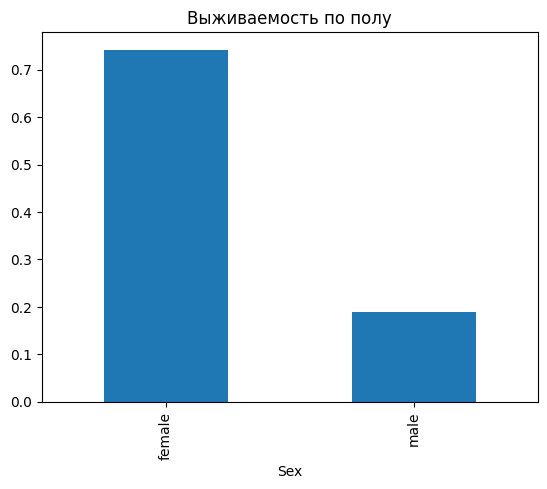

In [13]:
tables["Sex"]["survived_rate"].plot(kind="bar", title="Выживаемость по полу")

2. Выживаемость по классу

<Axes: title={'center': 'Выживаемость по классу'}, xlabel='Pclass'>

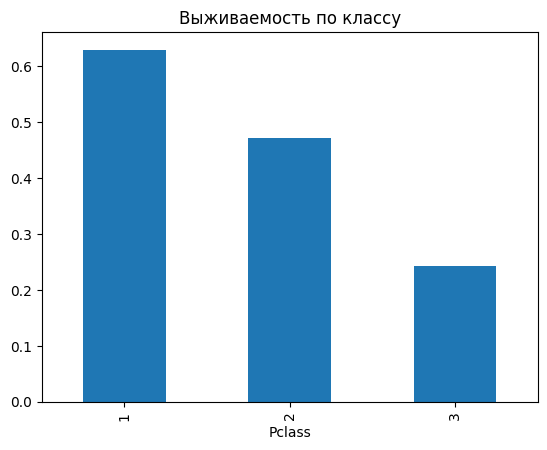

In [14]:
tables["Pclass"]["survived_rate"].plot(kind="bar", title="Выживаемость по классу")

3. По порту посадки

<Axes: title={'center': 'Выживаемость по порту посадки'}, xlabel='Embarked'>

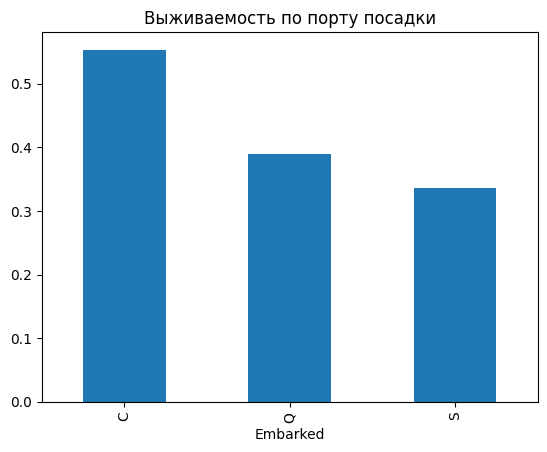

In [15]:
tables["Embarked"]["survived_rate"].plot(kind="bar", title="Выживаемость по порту посадки")

4. Выживаемость по титулу

<Axes: title={'center': 'Выживаемость по титулу'}, xlabel='Title'>

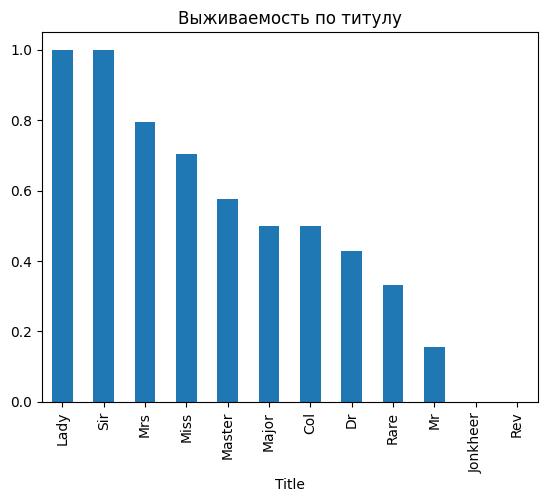

In [16]:
tables["Title"]["survived_rate"].plot(kind="bar", title="Выживаемость по титулу")

5. Выживаемость по палубе

<Axes: title={'center': 'Выживаемость по палубе (топ-10)'}, xlabel='CabinDeck'>

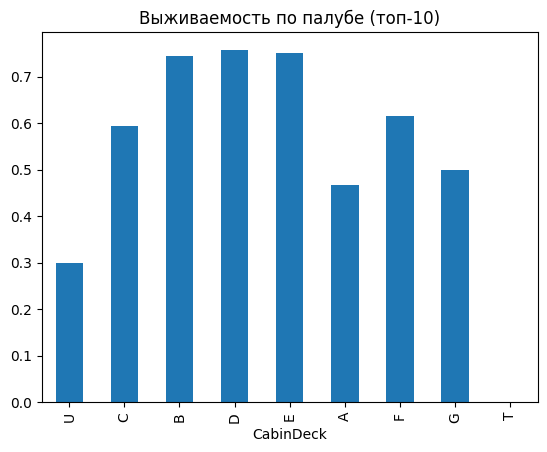

In [17]:
deck_counts = df["CabinDeck"].value_counts().head(10).index.tolist()
deck_table = survival_table("CabinDeck").reindex(deck_counts)
deck_table["survived_rate"].plot(kind="bar", title="Выживаемость по палубе (топ-10)")

6. По размеру семьи

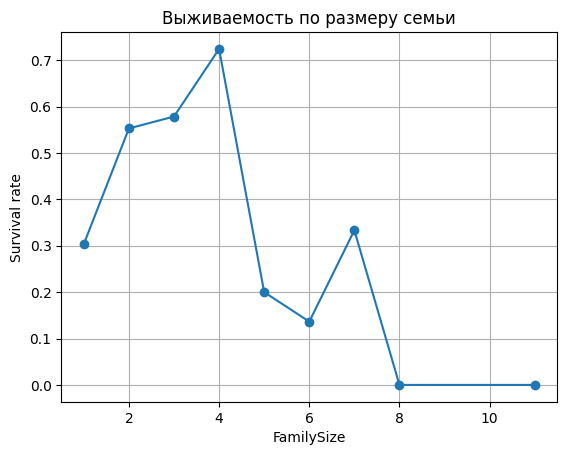

In [18]:
family_table = df.groupby("FamilySize").agg(count=("Survived","size"), survived_rate=("Survived","mean")).sort_index()
plt.figure()
plt.plot(family_table.index, family_table["survived_rate"], marker="o")
plt.title("Выживаемость по размеру семьи")
plt.xlabel("FamilySize")
plt.ylabel("Survival rate")
plt.grid(True)
plt.show()

7. По возрастным группам

<Axes: title={'center': 'Выживаемость по возрастным группам'}, xlabel='AgeGroup'>

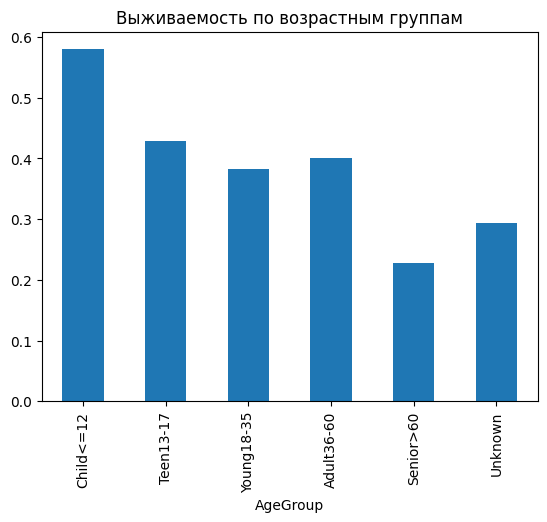

In [19]:
order_age = ["Child<=12","Teen13-17","Young18-35","Adult36-60","Senior>60","Unknown"]
ag_table = tables["AgeGroup"].reindex(order_age)
ag_table["survived_rate"].plot(kind="bar", title="Выживаемость по возрастным группам")

8. Распределение возраста

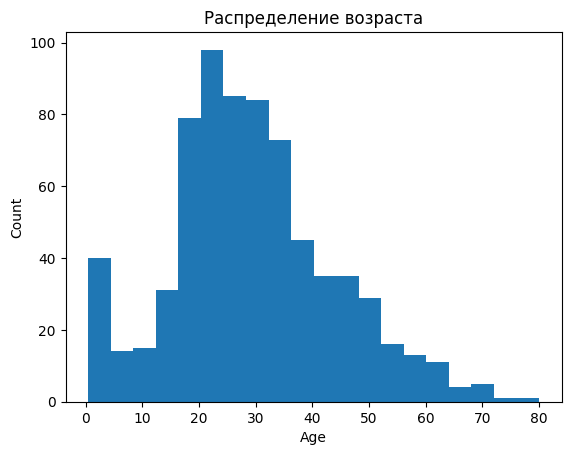

In [20]:
plt.figure()
plt.hist(df["Age"].dropna(), bins=20)
plt.title("Распределение возраста")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

9. Выживаемость по квартилям тарифа

<Axes: title={'center': 'Выживаемость по тарифным квартилям'}, xlabel='FareBin'>

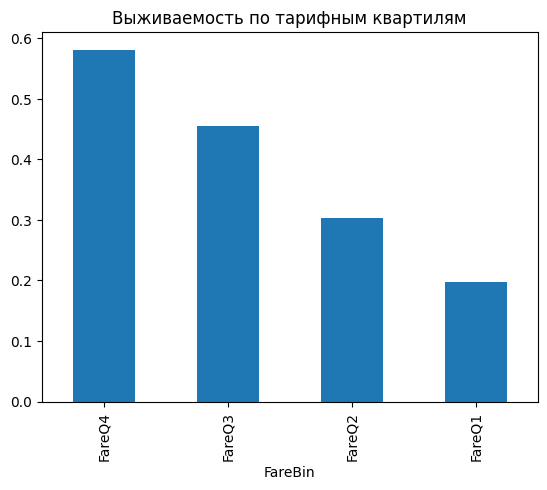

In [21]:
tables["FareBin"]["survived_rate"].plot(kind="bar", title="Выживаемость по тарифным квартилям")

10. Пропуски по признакам

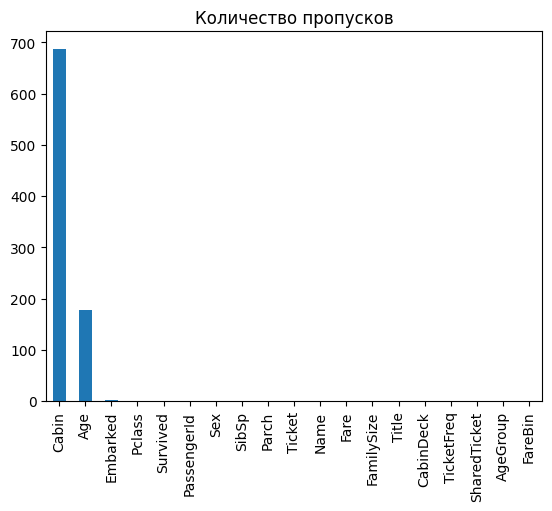

In [23]:
df.isnull().sum().sort_values(ascending=False).plot(kind="bar", title="Количество пропусков")
plt.show()

11. Корреляционная матрица

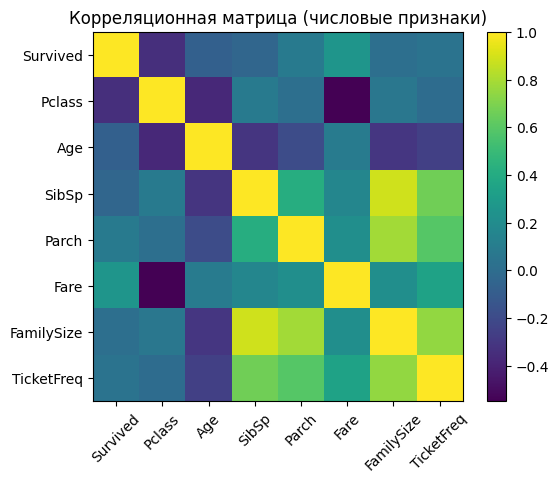

In [24]:
numeric_cols = ["Survived","Pclass","Age","SibSp","Parch","Fare","FamilySize","TicketFreq"]
corr = df[numeric_cols].corr()
plt.imshow(corr, interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Корреляционная матрица (числовые признаки)")
plt.show()

12. Распределение пассажиров по группам возраста

<Axes: title={'center': 'Распределение пассажиров по возрастным группам'}, xlabel='AgeGroup'>

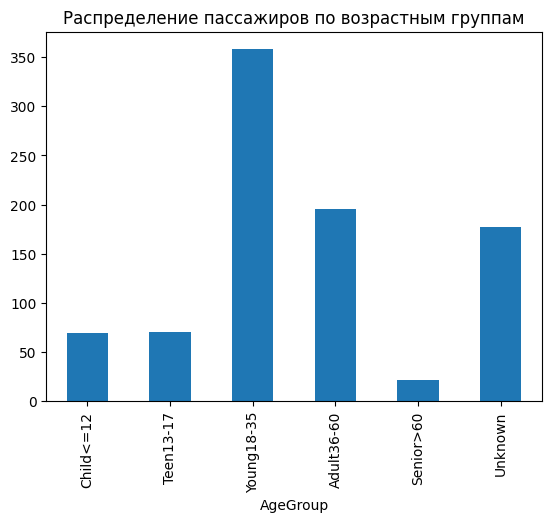

In [25]:
df["AgeGroup"].value_counts().loc[order_age].plot(kind="bar", title="Распределение пассажиров по возрастным группам")

13. Распределение пассажиров по FareBin

<Axes: title={'center': 'Распределение пассажиров по тарифным квартилям'}, xlabel='FareBin'>

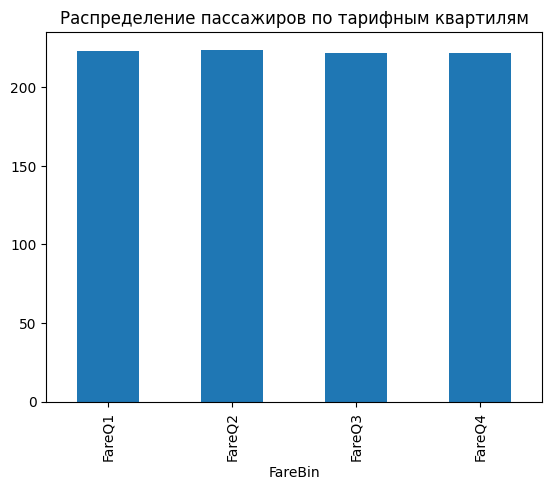

In [26]:

df["FareBin"].value_counts().sort_index().plot(kind="bar", title="Распределение пассажиров по тарифным квартилям")

Feature importance

In [ ]:
feature_imp = []
cat_features = ["Sex","Pclass","Embarked","Title","CabinDeck","SharedTicket","AgeGroup","FareBin"]
for col in cat_features:
    grp = df.groupby(col)["Survived"].mean()
    diff = grp.max() - grp.min()
    feature_imp.append((col, float(diff)))
feature_imp_df = pd.DataFrame(feature_imp, columns=["feature","survival_rate_range"]).sort_values("survival_rate_range", ascending=False)
feature_imp_df

C:\Users\User\AppData\Local\Temp\ipykernel_24944\1014433610.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(col)["Survived"].mean()


,feature,survival_rate_range
3,Title,1.000000
4,CabinDeck,0.757576
0,Sex,0.553130
1,Pclass,0.387267
7,FareBin,0.383772
6,AgeGroup,0.352437
5,SharedTicket,0.222360
2,Embarked,0.216615
